<a href="https://colab.research.google.com/github/arutraj/ML_Basics/blob/main/Solving_Image_Classification_problem_using_MLP_and_hyperparameter_tuning_in_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Steps to solve Emergency vehicle classification problem

<ol>1. Loading the dataset</ol>
<ol>2. Pre-processing the data</ol>
<ol>3. Creating training and validation set</ol>
<ol>4. Defining the model architecture</ol>
<ol>5. Compiling the model (defining loss function, optimizer)</ol>
<ol>6. Training the model</ol>
<ol>7. Evaluating model performance</ol>
<ol>8. Hyperparameter Tuning</ol>

## 1. Loading the dataset

In [2]:
# importing the required libraries
import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls /content/drive/MyDrive/AnalyticsVidya/DeepLearning/images |wc -l

2352


In [ ]:
!unzip /content/drive/My\ Drive/Dataset.zip

Archive:  /content/drive/My Drive/Dataset.zip
   creating: Dataset/
  inflating: Dataset/emergency_classification.csv  
   creating: Dataset/images/
  inflating: Dataset/images/0.jpg    
  inflating: Dataset/images/10.jpg   
  inflating: Dataset/images/1002.jpg  
  inflating: Dataset/images/1006.jpg  
  inflating: Dataset/images/1007.jpg  
  inflating: Dataset/images/1009.jpg  
  inflating: Dataset/images/1013.jpg  
  inflating: Dataset/images/1014.jpg  
  inflating: Dataset/images/1016.jpg  
  inflating: Dataset/images/1019.jpg  
  inflating: Dataset/images/102.jpg  
  inflating: Dataset/images/1020.jpg  
  inflating: Dataset/images/1022.jpg  
  inflating: Dataset/images/1023.jpg  
  inflating: Dataset/images/1026.jpg  
  inflating: Dataset/images/1031.jpg  
  inflating: Dataset/images/1035.jpg  
  inflating: Dataset/images/1036.jpg  
  inflating: Dataset/images/1037.jpg  
  inflating: Dataset/images/104.jpg  
  inflating: Dataset/images/1040.jpg  
  inflating: Dataset/images/1041.jpg

In [5]:
# reading the csv file
data = pd.read_csv('/content/drive/MyDrive/AnalyticsVidya/DeepLearning/emergency_classification.csv')

In [6]:
# creating a random seed
seed = 42

In [7]:
# looking at first five rows of the data
data.head()

,image_names,emergency_or_not
0,0.jpg,1
1,1.jpg,1
2,2.jpg,1
3,3.jpg,1
4,4.jpg,1


In [8]:
# load images and store it in numpy array

# empty list to store the images
X = []
# iterating over each image
for img_name in data.image_names:

    # loading the image using its name
    img = plt.imread('/content/drive/MyDrive/AnalyticsVidya/DeepLearning/images/' + img_name)

    # normalizing the pixel values
    img = img / 255

    # saving each image in the list
    X.append(img)

# converting the list of images into array
X=np.array(X)

# storing the target variable in separate variable
y = data.emergency_or_not.values

In [9]:
# shape of images
X.shape

(2352, 224, 224, 3)

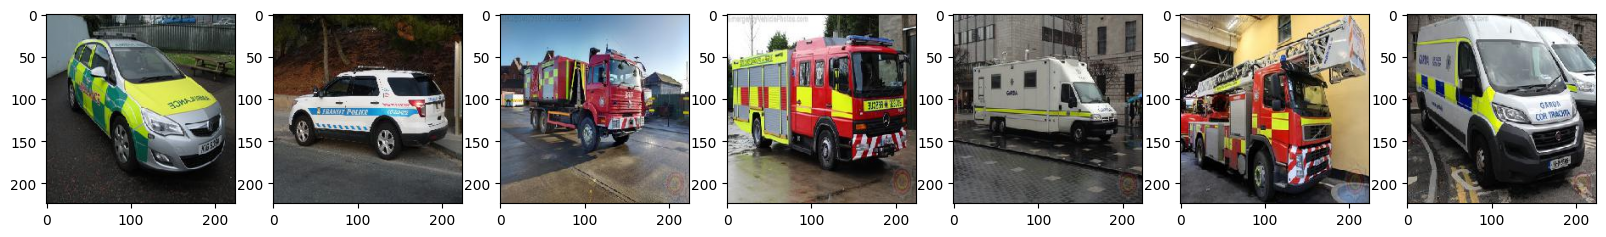

In [10]:
# glance at the images
fig, axes = plt.subplots(ncols=7,figsize=(20,10))
for i in range(7):
  axes[i].imshow(X[i])

## 2. Pre-processing the data

In [11]:
X = X.reshape(-1, 224*224*3).astype('float32')
X.shape

(2352, 150528)

## 3. Creating training and validation set

In [12]:
# creating a training and validation set
X_train, X_valid, y_train, y_valid=train_test_split(X,y,test_size=0.3, random_state=seed, stratify=y)

In [13]:
# shape of training and validation set
(X_train.shape, y_train.shape), (X_valid.shape, y_valid.shape)

(((1646, 150528), (1646,)), ((706, 150528), (706,)))

In [14]:
# importing torch library
import torch

In [15]:
# converting training and validation set to PyTorch tensor

X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)

X_valid = torch.FloatTensor(X_valid)
y_valid = torch.FloatTensor(y_valid)

## 4. Defining the model architecture

In [16]:
# importing functions from torch for defining the model architecture
import torch.nn as nn
from torch.nn import Linear, Sigmoid, Sequential

In [17]:
# defining the architecture of the model

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.linear_layers = Sequential(
            Linear(X_train.shape[1],100),
            Sigmoid(),
            Linear(100, 1),
            Sigmoid())

    # Defining the forward pass
    def forward(self, x):
        x = self.linear_layers(x)
        return x

## 5. Compiling the model (defining loss function, optimizer)

In [18]:
from torch.nn import BCELoss
from torch.optim import Adam

In [19]:
# for same default initialization
torch.manual_seed(32)

# defining the model
model = Net()

# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.01)

# defining the loss function
criterion = BCELoss()

# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

print(model)

Net(
  (linear_layers): Sequential(
    (0): Linear(in_features=150528, out_features=100, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=100, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


## 6. Training the model

In [20]:
# batch size of the model
batch_size = 64

for epoch in tqdm(range(50)):
    # setting initial loss as 0
    train_loss = 0.0

    # to randomly pick the images without replacement in batches
    permutation = torch.randperm(X_train.size()[0])

    # to keep track of training loss
    training_loss = []

    # for loop for training on batches
    for i in range(0,X_train.size()[0], batch_size):

        # defining the training phase
        model.train()

        # taking the indices from randomly generated values
        indices = permutation[i:i+batch_size]

        # getting the images and labels for a batch
        batch_x, batch_y = X_train[indices], y_train[indices]

        if torch.cuda.is_available():
            batch_x, batch_y = batch_x.cuda(), batch_y.cuda()

        # clearing all the accumulated gradients
        optimizer.zero_grad()

        # mini batch computation
        #outputs = model(batch_x)
        outputs = model(batch_x).squeeze(1)

        # Reshape batch_y to match outputs
        #batch_y = batch_y.unsqueeze(1)  # Add a dimension to batch_y

        # calculating the loss for a mini batch
        loss = criterion(outputs,batch_y)

        # storing the loss for every mini batch
        training_loss.append(loss.item())

        # calculating the gradients
        loss.backward()

        # updating the parameters
        optimizer.step()

    training_loss = np.average(training_loss)
    if epoch%10 == 0:
        # printing the loss
        print('epoch: \t', epoch, '\t training loss: \t', training_loss)

  2%|▏         | 1/50 [00:01<01:07,  1.37s/it]

epoch: 	 0 	 training loss: 	 0.7313843988455259


 22%|██▏       | 11/50 [00:07<00:22,  1.74it/s]

epoch: 	 10 	 training loss: 	 0.6864600135729864


 42%|████▏     | 21/50 [00:13<00:16,  1.75it/s]

epoch: 	 20 	 training loss: 	 0.6920875287972964


 62%|██████▏   | 31/50 [00:19<00:11,  1.72it/s]

epoch: 	 30 	 training loss: 	 0.6864943389709179


 82%|████████▏ | 41/50 [00:24<00:05,  1.75it/s]

epoch: 	 40 	 training loss: 	 0.6827773818602929


100%|██████████| 50/50 [00:30<00:00,  1.65it/s]


## 7. Evaluating model performance

In [21]:
# prediction for training set
train_prediction = []
train_target = []
permutation = torch.randperm(X_train.size()[0])
for i in tqdm(range(0,X_train.size()[0], batch_size)):
    # prediction phase
    model.eval()
    indices = permutation[i:i+batch_size]
    batch_x, batch_y = X_train[indices], y_train[indices]

    if torch.cuda.is_available():
        batch_x, batch_y = batch_x.cuda(), batch_y.cuda()

    with torch.no_grad():
        output = model(batch_x).data.cpu()

    # converting the predicted probabilities into labels
    train_predicted_label = []
    for i in output:
        # defining the threshold value as 0.5
        if i>=0.5:
            train_predicted_label.append(1)
        else:
            train_predicted_label.append(0)
    train_prediction.append(train_predicted_label)
    train_target.append(batch_y)

100%|██████████| 26/26 [00:00<00:00, 62.41it/s]


In [22]:
# training accuracy
training_accuracy = []
for i in range(len(train_prediction)):
    training_accuracy.append(accuracy_score(train_target[i].data.cpu(),train_prediction[i]))

print('training accuracy: \t', np.average(training_accuracy))

training accuracy: 	 0.5794575668896321


In [24]:
# prediction for validation set
valid_prediction = []
valid_target = []
permutation = torch.randperm(X_valid.size()[0])
for i in tqdm(range(0,X_valid.size()[0], batch_size)):
    model.eval()
    indices = permutation[i:i+batch_size]
    batch_x, batch_y = X_valid[indices], y_valid[indices]

    if torch.cuda.is_available():
        batch_x, batch_y = batch_x.cuda(), batch_y.cuda()

    with torch.no_grad():           # no grad for eval()
      #output = model(batch_x)
      output = model(batch_x.cuda()).data.cpu()
    # converting the predicted probabilities into labels
    valid_predicted_label = []
    for i in output:
        # defining the threshold value as 0.5
        if i>=0.5:
            valid_predicted_label.append(1)
        else:
            valid_predicted_label.append(0)
    valid_prediction.append(valid_predicted_label)
    valid_target.append(batch_y)

100%|██████████| 12/12 [00:00<00:00, 48.19it/s]


In [ ]:
# validation accuracy
valid_accuracy = []
for i in range(len(valid_prediction)):
    valid_accuracy.append(accuracy_score(valid_target[i].data.cpu(),valid_prediction[i]))

print('validation accuracy: \t', np.average(valid_accuracy))

validation accuracy: 	 0.5325520833333334


## 8. Hyperparameter Tuning

In [25]:
# importing batchnorm and dropout layers
from torch.nn import BatchNorm1d, Dropout

In [26]:
# defining the architecture of the model

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.linear_layers = Sequential(
            Linear(X_train.shape[1],100),
            Sigmoid(),
            # adding batch normalization layer
            BatchNorm1d(100),
            # adding dropout layer
            Dropout(0.85, inplace=True),
            Linear(100, 100),
            Sigmoid(),
            # adding batch normalization layer
            BatchNorm1d(100),
            # adding dropout layer
            Dropout(0.85, inplace=True),
            Linear(100, 1),
            Sigmoid())

    # Defining the forward pass
    def forward(self, x):
        x = self.linear_layers(x)
        return x

In [27]:
# for same default initialization
torch.manual_seed(32)

# defining the model
model = Net()

# defining the optimizer
# reducing the learning rate to 1e-5
optimizer = Adam(model.parameters(), lr=1e-5)

# defining the loss function
criterion = BCELoss()

# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

print(model)

Net(
  (linear_layers): Sequential(
    (0): Linear(in_features=150528, out_features=100, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.85, inplace=True)
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): Sigmoid()
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.85, inplace=True)
    (8): Linear(in_features=100, out_features=1, bias=True)
    (9): Sigmoid()
  )
)


In [28]:
# batch size of the model
# increasing the batch size from 64 to 128
batch_size = 128

# increasing the number of epochs from 50 to 100
for epoch in tqdm(range(100)):

    # keep track of training and validation loss
    train_loss = 0.0

    permutation = torch.randperm(X_train.size()[0])

    training_loss = []
    for i in range(0,X_train.size()[0], batch_size):

        model.train()
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X_train[indices], y_train[indices]

        if torch.cuda.is_available():
            batch_x, batch_y = batch_x.cuda(), batch_y.cuda()

        optimizer.zero_grad()
        # in case you wanted a semi-full example
        outputs = model(batch_x).squeeze(1)
        # Reshape batch_y to match outputs
        #batch_y = batch_y.unsqueeze(1)  # Add a dimension to batch_y
        loss = criterion(outputs,batch_y)

        training_loss.append(loss.item())
        loss.backward()
        optimizer.step()

    training_loss = np.average(training_loss)
    if epoch%10 == 0:
        # printing the loss
        print('epoch: \t', epoch, '\t training loss: \t', training_loss)

  1%|          | 1/100 [00:00<01:11,  1.38it/s]

epoch: 	 0 	 training loss: 	 0.8887908504559443


 11%|█         | 11/100 [00:06<00:52,  1.70it/s]

epoch: 	 10 	 training loss: 	 0.7440947477634137


 21%|██        | 21/100 [00:12<00:45,  1.74it/s]

epoch: 	 20 	 training loss: 	 0.6861989177190341


 31%|███       | 31/100 [00:18<00:40,  1.69it/s]

epoch: 	 30 	 training loss: 	 0.6477479751293476


 41%|████      | 41/100 [00:24<00:34,  1.70it/s]

epoch: 	 40 	 training loss: 	 0.6425794546420758


 51%|█████     | 51/100 [00:30<00:29,  1.65it/s]

epoch: 	 50 	 training loss: 	 0.5615605322214273


 61%|██████    | 61/100 [00:36<00:22,  1.73it/s]

epoch: 	 60 	 training loss: 	 0.5253917964605185


 71%|███████   | 71/100 [00:42<00:17,  1.62it/s]

epoch: 	 70 	 training loss: 	 0.4724007982474107


 81%|████████  | 81/100 [00:48<00:11,  1.69it/s]

epoch: 	 80 	 training loss: 	 0.4254280993571648


 91%|█████████ | 91/100 [00:55<00:05,  1.61it/s]

epoch: 	 90 	 training loss: 	 0.38712406616944534


100%|██████████| 100/100 [01:00<00:00,  1.65it/s]


In [31]:
# prediction for training set
train_prediction = []
train_target = []
permutation = torch.randperm(X_train.size()[0])
for i in tqdm(range(0,X_train.size()[0], batch_size)):
    model.eval()
    indices = permutation[i:i+batch_size]
    batch_x, batch_y = X_train[indices], y_train[indices]

    if torch.cuda.is_available():
        batch_x, batch_y = batch_x.cuda(), batch_y.cuda()

    with torch.no_grad():
        output = model(batch_x)

    # converting the predicted probabilities into labels
    train_predicted_label = []
    for i in output:
        # defining the threshold value as 0.5
        if i>=0.5:
            train_predicted_label.append(1)
        else:
            train_predicted_label.append(0)
    train_prediction.append(train_predicted_label)
    train_target.append(batch_y)

# training accuracy
training_accuracy = []
for i in range(len(train_prediction)):
    training_accuracy.append(accuracy_score(train_target[i].data.cpu(),train_prediction[i]))

print('training accuracy: \t', np.average(training_accuracy))

100%|██████████| 13/13 [00:00<00:00, 18.60it/s]

training accuracy: 	 0.9677556818181817


In [33]:
torch.cuda.is_available()

True

In [34]:
# prediction for validation set
valid_prediction = []
valid_target = []
permutation = torch.randperm(X_valid.size()[0])
for i in tqdm(range(0,X_valid.size()[0], batch_size)):
    model.eval()
    indices = permutation[i:i+batch_size]
    batch_x, batch_y = X_valid[indices], y_valid[indices]

    if torch.cuda.is_available():
        batch_x, batch_y = batch_x.cuda(), batch_y.cuda()

    with torch.no_grad():
        output = model(batch_x)

    # converting the predicted probabilities into labels
    valid_predicted_label = []
    for i in output:
        # defining the threshold value as 0.5
        if i>=0.5:
            valid_predicted_label.append(1)
        else:
            valid_predicted_label.append(0)
    valid_prediction.append(valid_predicted_label)
    valid_target.append(batch_y)

# validation accuracy
valid_accuracy = []
for i in range(len(valid_prediction)):
    valid_accuracy.append(accuracy_score(valid_target[i].data.cpu(),valid_prediction[i]))

print('validation accuracy: \t', np.average(valid_accuracy))

100%|██████████| 6/6 [00:00<00:00, 18.67it/s]

validation accuracy: 	 0.7084517045454546
